## Preprocessing XRAY
#### - All images are dicom
#### - Original images shape 1024 x 1024
#### - Resize images to 224 x 224
#### - Bounding boxes are also need to be scaled; 
#### - This project skipped this as labels are created on rescaled images of 224x224
#### - Split train set to 400 train and 96 valid images
#### - Standardize the pixel values into interval [0, 1] by scaling 1/255
#### - Compute training mean and std dev for normalization

## Dataset
#### - Custom Dataset of 496 samples
#### - Task = Given a subject idx, load the corresponding X-Ray image 
#### and bounding box and coordinates(xmin, xmax, ymin and ymax)
#### - Z- normalize $x_{norm} = \frac{x - \mu}{\sigma}$
#### - Data augmentation:
#### Gamma contrast changes (0.7, 1.7)
#### Scaling (0.8, 1.2)
#### Rotation (-10, 10)
#### Translation (-10px, 10px)
#### VVI: Augment the image and bounding box identically

## Training
#### Network architecture: ResNet 18
#### Change input channels from 3 to 1
#### Change output dimension from 1000 to 4
#### MSE Loss

In [1]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm

In [2]:
# root: /ocean/projects/asc170022p/shg121/POC/Med-AI-Course
labels = pd.read_csv("./data/rsna-pneumonia-detection-challenge/rsna_heart_detection.csv")
labels.head()

,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,91,71,77,102,ca112a3c-b701-48b8-a94f-725ea65416a7,224,224
1,heart,70,64,89,67,e5f292ae-f1e5-497c-b0a0-68f1aa2196b2,224,224
2,heart,82,55,81,76,67af68f7-7ba0-49a0-a373-3a8801eb0faa,224,224
3,heart,93,74,78,89,814289a3-9ce8-4cba-842f-45d6a36f540d,224,224
4,heart,85,61,85,93,e508969f-c931-462b-aa90-ccde34a4d9e5,224,224


In [3]:
ROOT_PATH = Path("./data/rsna-pneumonia-detection-challenge/stage_2_train_images/")
SAVE_PATH = Path("./data/rsna-pneumonia-detection-challenge/Processed-Heart-Detection")

ca112a3c-b701-48b8-a94f-725ea65416a7
data/rsna-pneumonia-detection-challenge/stage_2_train_images/ca112a3c-b701-48b8-a94f-725ea65416a7.dcm
e5f292ae-f1e5-497c-b0a0-68f1aa2196b2
data/rsna-pneumonia-detection-challenge/stage_2_train_images/e5f292ae-f1e5-497c-b0a0-68f1aa2196b2.dcm
67af68f7-7ba0-49a0-a373-3a8801eb0faa
data/rsna-pneumonia-detection-challenge/stage_2_train_images/67af68f7-7ba0-49a0-a373-3a8801eb0faa.dcm
814289a3-9ce8-4cba-842f-45d6a36f540d
data/rsna-pneumonia-detection-challenge/stage_2_train_images/814289a3-9ce8-4cba-842f-45d6a36f540d.dcm


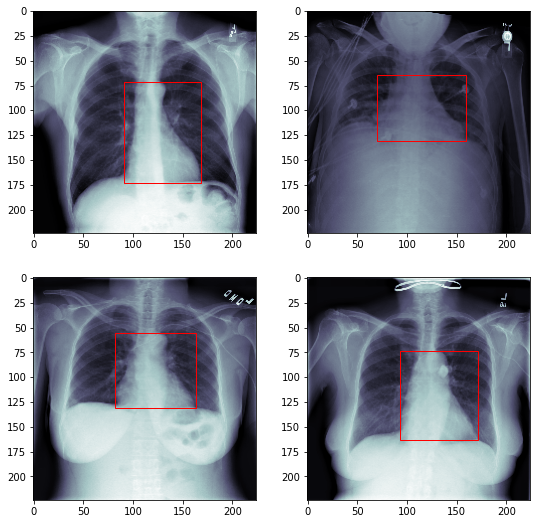

In [4]:
# visualize
fig, axis = plt.subplots(2, 2, figsize = (9,9))
c = 0
for i in range(2):
    for j in range(2):
        data = labels.iloc[c]
        patient_id = data["name"]
        # appending paths to path object
        print(patient_id)
        dcm_path = ROOT_PATH/str(patient_id)
        # For dicom images we need to add extensions
        dcm_path = dcm_path.with_suffix(".dcm")
        print(dcm_path)
        dcm = pydicom.read_file(dcm_path).pixel_array
        dcm_array = cv2.resize(dcm, (224, 224))
        
        x = data["x0"]
        y = data["y0"]
        width = data["w"]
        height = data["h"]
        
        axis[i][j].imshow(dcm_array, cmap="bone")
        rect = patches.Rectangle(
            (x, y), 
            width, 
            height, 
            linewidth=1,
            edgecolor="r",
            facecolor="none"
        )
        axis[i][j].add_patch(rect)
        c+=1

## Standardize / Normalize

In [5]:
sums, sums_squared = 0, 0
train_ids = []
val_ids = []

for counter, patient_id in enumerate(list(labels.name)):
    dcm_path = ROOT_PATH/str(patient_id)
    # For dicom images we need to add extensions
    dcm_path = dcm_path.with_suffix(".dcm")
    dcm = pydicom.read_file(dcm_path).pixel_array
    # Standardize
    dcm_array = (cv2.resize(dcm, (224, 224)) / 255).astype(np.float16)
    
    train_or_val = "train" if counter < 400 else "val"
    
    if train_or_val == "train":
        train_ids.append(patient_id)
    else:
        val_ids.append(patient_id)
        
    current_save_path = SAVE_PATH/train_or_val
    current_save_path.mkdir(parents=True, exist_ok=True)
    
    #.npy extension will be automatically appended to patientid
    np.save(current_save_path/patient_id, dcm_array)
    
    normalizer = 224*224
    if train_or_val == "train":
        sums += np.sum(dcm_array)/normalizer
        sums_squared +=(dcm_array ** 2).sum() / normalizer 
    

In [6]:
np.save(
    "./data/rsna-pneumonia-detection-challenge/Processed-Heart-Detection/train_subjects",
    train_ids
)

np.save(
    "./data/rsna-pneumonia-detection-challenge/Processed-Heart-Detection/val_subjects",
    val_ids
)

In [8]:
mean = sums / len(train_ids)
std = np.sqrt((sums_squared/len(train_ids)) - mean ** 2)
# mean = 0.49430165816326493
# std = 0.2527964897943661
print(mean)
print(std)

0.49430165816326493
0.2527964897943661


## Dataset

In [9]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import imgaug
from imgaug.augmentables.bbs import BoundingBox

In [10]:
class CardiacDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_labels_csv, patients, root_path, augs):
        self.labels = pd.read_csv(path_to_labels_csv)
        self.patients = np.load(patients)
        self.root_path = Path(root_path)
        self.augment = augs
    
    def __len__(self):
        return len(self.patients)
    
    def __getitem__(self, idx):
        patient = self.patients[idx]
        data = self.labels[self.labels["name"]==patient]
        
        x_min = data["x0"].item()
        y_min = data["y0"].item()
        x_max = x_min + data["w"].item()
        y_max = y_min + data["h"].item()
        bbox = [x_min, y_min, x_max, y_max]
        
        file_path = self.root_path/patient
        img = np.load(f"{file_path}.npy").astype(np.float32)
        
        if self.augment:
            bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
            # to sync with pytorch multithreading
            random_seed = torch.randint(0, 100000, (1,)).item()
            imgaug.seed(random_seed)
            
            # augment images and bbox
            img, aug_bbox = self.augment(image=img, bounding_boxes=bb)
            # extract bbox coordinates
#             aug_bbox[0][0] # x cordinate of the top left corner 
#             aug_bbox[0][1], \# y cordingate of the top left corner
#             aug_bbox[1][0],  \# x coodinate of the bottom right corner
#             aug_bbox[1][1]# y coodinate of the bottom right corner
                
            bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]
        
        img = (img - mean) / std
         
        # add the channel dimension
        img = torch.tensor(img).unsqueeze(0)
        bbox = torch.tensor(bbox)
        return img, bbox
            
        

## test dataset class

In [12]:
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [13]:
seq = iaa.Sequential([
    iaa.GammaContrast(),
    iaa.Affine(
        scale=(0.8, 1.2),
        rotate=(-10, 10),
        translate_px=(-10, 10)
    )
])

In [14]:
labels_path = "./data/rsna-pneumonia-detection-challenge/rsna_heart_detection.csv"
patients_path = "./data/rsna-pneumonia-detection-challenge/Processed-Heart-Detection/train_subjects.npy"
train_root = "./data/rsna-pneumonia-detection-challenge/Processed-Heart-Detection/train/"

dataset = CardiacDataset(labels_path, patients_path, train_root, seq)


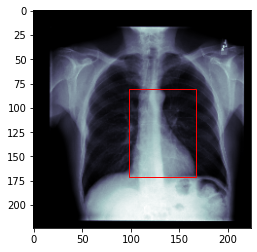

In [15]:
img, bbox = dataset[0]
fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], edgecolor="r", facecolor="none")
axis.add_patch(rect)

## Training pipeline

In [16]:
import torch
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
import cv2 
import imgaug.augmenters as iaa

In [17]:
labels_path = "./data/rsna-pneumonia-detection-challenge/rsna_heart_detection.csv"
train_root = "./data/rsna-pneumonia-detection-challenge/Processed-Heart-Detection/train"
train_subjects = "./data/rsna-pneumonia-detection-challenge/Processed-Heart-Detection/train_subjects.npy"

val_root = "./data/rsna-pneumonia-detection-challenge/Processed-Heart-Detection/val"
val_subjects = "./data/rsna-pneumonia-detection-challenge/Processed-Heart-Detection/val_subjects.npy"

train_transforms = iaa.Sequential([
    iaa.GammaContrast(),
    iaa.Affine(
        scale=(0.8, 1.2),
        rotate=(-10, 10),
        translate_px=(-10, 10)
    )
])

In [18]:
train_dataset = CardiacDataset(labels_path, train_subjects, train_root, train_transforms)
val_dataset = CardiacDataset(labels_path, val_subjects, val_root, None)

In [19]:
batch_size = 8
num_workers = 4

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size,
    num_workers=num_workers, 
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=batch_size,
    num_workers=num_workers, 
    shuffle=False
)

In [20]:
image, bbox = iter(train_loader).next()
print(image.size())
print(bbox)

torch.Size([8, 1, 224, 224])
tensor([[108.0970,  80.8069, 187.8245, 191.0077],
        [ 80.6000,  59.5233, 163.6929, 168.1620],
        [ 88.6502,  60.1742, 175.2443, 152.8779],
        [ 95.7304,  68.8786, 178.5130, 163.4167],
        [ 73.5232,  59.2941, 150.4907, 159.2916],
        [ 88.2301,  60.0875, 150.7123, 118.8118],
        [ 78.1189,  59.3430, 145.3272, 124.2466],
        [ 95.4866,  34.6366, 189.5935, 153.0546]])


In [21]:
class CardiacDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.conv1 = torch.nn.Conv2d(
            in_channels=1,
            out_channels=64,
            kernel_size=(7,7),
            stride=(2, 2),
            padding=(3, 3),
            bias=False
        )
        
        self.model.fc = torch.nn.Linear(in_features=512, out_features=4)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 1e-4)
        self.loss_fn = torch.nn.MSELoss()
        
    def forward(self, data):
        return self.model(data)
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)
        
        self.log("Train_Loss", loss)
        
        if batch_idx%50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)
        
        self.log("Val_Loss", loss)
        
        if batch_idx%50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
        
        return loss
    
    def log_images(self, x_ray, pred, label, name):
        results = []
        
        for i in range(4):
            coords_labels = label[i]
            coords_pred = pred[i]
        
            img = ((x_ray[i] * std) + mean).numpy()[0]
            
            # Ground truth
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)
            
            # predictions
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)
            
            results.append(torch.tensor(img).unsqueeze(0))
            
        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(f"{name} Prediction vs Label", grid, self.global_step)
        
    def configure_optimizers(self):
        return [self.optimizer]

In [35]:
model = CardiacDetectionModel()
checkpoint_callback = ModelCheckpoint(
    monitor="Val_Loss",
    dirpath="./Cardiac_detection/chkpt",
    filename="cardiac-{epoch:02d}",
    save_top_k=10,
    mode ="min" # for best accuracy not worst
) 

In [36]:
trainer = pl.Trainer(
    gpus=1, 
    logger=TensorBoardLogger("./Cardiac_detection/logs"), 
    log_every_n_steps=1,
    callbacks=checkpoint_callback,
    max_epochs=100
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [37]:
trainer.fit(model, train_loader, val_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name    | Type    | Params
------------------------------------
0 | model   | ResNet  | 11.2 M
1 | loss_fn | MSELoss | 0     
------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.689    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
!df -h /ocean/projects/asc170022p/shg121

In [27]:
!du -s /ocean/projects/asc170022p/shg121


^C


## Testing the model

In [38]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.load_from_checkpoint("./Cardiac_detection/chkpt/cardiac-epoch=99.ckpt")
model.eval()
model.to(device)

CardiacDetectionModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [40]:
preds = []
labels = []

with torch.no_grad():
    for data, label in val_dataset:
        data = data.to(device).float().unsqueeze(0)
        pred = model(data)[0].cpu()
        preds.append(pred)
        labels.append(label)
        
preds = torch.stack(preds)
labels = torch.stack(labels)

In [42]:
abs(preds - labels).mean(0) # mean diff b/w preds and labes x0, y0, x1, y1

tensor([4.5580, 4.4367, 6.5359, 5.6288])

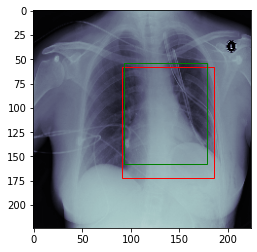

In [47]:
IDX = 10
img, label = val_dataset[IDX]
pred = preds[IDX]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
heart_pred = patches.Rectangle((pred[0], pred[1]), pred[2]-pred[0], pred[3]-pred[1], edgecolor="r", facecolor="none")
heart_GT = patches.Rectangle((label[0], label[1]), label[2]-label[0], label[3]-label[1], edgecolor="g", facecolor="none")
axis.add_patch(heart_pred)
axis.add_patch(heart_GT)
